In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import norm
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from config import ORDER, JOURNAL_MAP

plt.rcParams["font.family"] = "Arial"
plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams["text.usetex"] = True

df_sample = pd.read_csv("../data/focal_papers.csv")
df_generated = pd.read_csv("../data/generated_references.csv")
df_ground_truth = pd.read_csv("../data/ground_truth_references.csv")

# existing vs non-existent
df_existing = df_generated[df_generated["Exists"] == 1.0]
df_non_existent = df_generated[df_generated["Exists"] == 0.0]

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_30856/2153734850.py:18: DtypeWarning: Columns (4,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_generated = pd.read_csv("../data/generated_references.csv")


In [2]:
# additional computations

# years
starting_year = 1970
all_years = pd.date_range(
    "1970", periods=2024-starting_year, freq="YE"
).year

year_mask_gen = df_generated["Publication Year"].apply(
    lambda x: str(x).replace(".", "", 1).isdigit() 
    if not pd.isna(x) else True
)
df_generated.loc[~year_mask_gen, "Publication Year"] = np.nan
df_generated["Publication Year"] = df_generated[
    "Publication Year"
].astype(float)

df_generated["Publication Year_limited"] = df_generated["Publication Year"]
df_generated.loc[
    df_generated["Publication Year_limited"] < starting_year, "Publication Year_limited"
] = starting_year

year_mask_ground = df_ground_truth["Year_x"].apply(
    lambda x: str(x).replace(".", "", 1).isdigit()
    if not pd.isna(x) else True
)
df_ground_truth.loc[~year_mask_ground, "Year_x"] = np.nan
df_ground_truth[
    "Publication Year"
] = df_ground_truth["Year_x"].astype(float)
df_ground_truth["Publication Year_limited"] = df_ground_truth["Publication Year"]
df_ground_truth.loc[
    df_ground_truth["Publication Year_limited"] < starting_year, "Publication Year_limited"
] = starting_year

# relative frequencies over time
intro_year = df_ground_truth[
    "Publication Year_limited"
].value_counts().sort_index().reindex(all_years, fill_value=0)
gen_year = df_generated[
    "Publication Year_limited"
].value_counts().sort_index().reindex(all_years, fill_value=0)
exist_year = df_generated[
    df_generated["Exists"] == 1
]["Publication Year_limited"].value_counts().sort_index().reindex(all_years, fill_value=0)
non_exist_year = df_generated[
    df_generated["Exists"] == 0
]["Publication Year_limited"].value_counts().sort_index().reindex(all_years, fill_value=0)

intro_year = intro_year / intro_year.sum()
gen_year = gen_year / gen_year.sum()
exist_year = exist_year / exist_year.sum()
non_exist_year = non_exist_year / non_exist_year.sum()

# number of authors
etal_mask_generated = df_generated["Number of Authors"].apply(
    lambda x: str(x).replace('.', '').isdigit() if not pd.isna(x) else True
)
etal_mask_exist = df_existing["Number of Authors"].apply(
    lambda x: str(x).replace('.', '').isdigit() if not pd.isna(x) else True
)
etal_mask_non_exist = df_non_existent["Number of Authors"].apply(
    lambda x: str(x).replace('.', '').isdigit() if not pd.isna(x) else True
)

df_generated.loc[~etal_mask_generated, "Number of Authors"] = "et al."
df_existing.loc[~etal_mask_exist, "Number of Authors"] = "et al."
df_non_existent.loc[~etal_mask_non_exist, "Number of Authors"] = "et al."

df_generated["Number of Authors"] = df_generated["Number of Authors"].apply(
    lambda x: float(x) if str(x).replace('.', '').isdigit() else x
)
df_existing["Number of Authors"] = df_existing["Number of Authors"].apply(
    lambda x: float(x) if str(x).replace('.', '').isdigit() else x
)
df_non_existent["Number of Authors"] = df_non_existent["Number of Authors"].apply(
    lambda x: float(x) if str(x).replace('.', '').isdigit() else x
)

gen_authors = df_generated["Number of Authors"].to_frame()
gen_authors["Category"] = "gen"
exist_authors = df_existing["Number of Authors"].to_frame()
exist_authors["Category"] = "exist"
not_exist_authors = df_non_existent["Number of Authors"].to_frame()
not_exist_authors["Category"] = "not_exist"
groundtruth_authors = df_ground_truth["Team_Size_x"].to_frame()
groundtruth_authors.columns = ["Number of Authors"]
groundtruth_authors["Category"] = "groundtruth"

df_authors = pd.concat(
    [groundtruth_authors, gen_authors, exist_authors, not_exist_authors],
    ignore_index=True
)

etal_mask = df_authors["Number of Authors"] == "et al."
etal = df_authors[etal_mask]

etal_authors = etal.groupby("Category").size() / df_authors.groupby("Category").size()
etal_authors.dropna(inplace=True)
etal_authors = etal_authors.reindex(["groundtruth", "gen", "exist", "not_exist"])
etal_authors.drop("groundtruth", inplace=True)

df_authors = df_authors[~etal_mask]

df_authors["Number of Authors"] = df_authors["Number of Authors"].astype(float)
df_authors.loc[df_authors["Number of Authors"] >= 9, "Number of Authors"] = 9

df_ground_truth.loc[df_ground_truth["Team_Size_x"] >= 9, "Team_Size_x"] = 9

# Title length
df_ground_truth["Title Length"] = df_ground_truth["PaperTitle"].apply(
    lambda x: len(x) if not pd.isna(x) else np.nan
)
df_generated["Title Length"] = df_generated["Title"].apply(
    lambda x: len(x) if not pd.isna(x) else np.nan
)
df_existing["Title Length"] = df_existing["Title"].apply(
    lambda x: len(x) if not pd.isna(x) else np.nan
)
df_non_existent["Title Length"] = df_non_existent["Title"].apply(
    lambda x: len(x) if not pd.isna(x) else np.nan
)

intro_length = df_ground_truth["Title Length"].to_frame()
intro_length["Category"] = "intro"
gen_length = df_generated["Title Length"].to_frame()
gen_length["Category"] = "gen"
exist_length = df_generated.loc[df_generated["Exists"] == 1.0, "Title Length"].to_frame()
exist_length["Category"] = "exist"
not_exist_length = df_generated.loc[df_generated["Exists"] == 0.0, "Title Length"].to_frame()
not_exist_length["Category"] = "not_exist"

df_length = pd.concat(
    [intro_length, gen_length, exist_length, not_exist_length],
    ignore_index=True
)

df_length.loc[df_length["Title Length"] < 25, "Title Length"] = 25
df_length.loc[df_length["Title Length"] > 160, "Title Length"] = 160

# journals
ground_truth_all = {'Nature': 2948,
 'PNAS': 2827,
 'Science': 2711,
 'Journal of Biological Chemistry': 2657,
 'Journal of the American Chemical Society': 2292,
 'Physical Review Letters': 1576,
 'The New England Journal of Medicine': 1499,
 'PLOS ONE': 1282,
 'Applied Physics Letters': 1261,
 'The Lancet': 1165,
 }

existing_gen_all = {'Nature': 2773,
 'Science': 2633,
 'The New England Journal of Medicine': 1504,
 'PNAS': 1208,
 'Cell': 1026,
 'The Lancet': 902,
 'Physical Review Letters': 732,
 'JAMA': 675,
 'Chemical Reviews': 670,
 'Circulation': 524,
 }

nonexistent_gen_all = {'Journal of the American Chemical Society': 1222,
 'Nature': 1157,
 'Journal of Biological Chemistry': 960,
 'Chemical Reviews': 933,
 'Science': 910,
 'The New England Journal of Medicine': 734,
 'The Lancet': 713,
 'Journal of Applied Physics': 664,
 'PNAS': 658,
 'Physical Review B': 628,
 }

def top_n(d, n=10):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=True)[:n])

def get_rank_and_freq(d, journal):
    if journal in d:
        sorted_j = sorted(d.items(), key=lambda x: x[1], reverse=True)
        rank_j = [j for j,_ in sorted_j].index(journal) + 1
        freq_j = d[journal]
        return rank_j, freq_j
    return None, None

gt_top10 = top_n(ground_truth_all)
eg_top10 = top_n(existing_gen_all)
neg_top10 = top_n(nonexistent_gen_all)

all_journals = set(gt_top10.keys()) | set(eg_top10.keys()) | set(neg_top10.keys())
categories = ["Ground truth", "Existing generations", "Non-existent generations"]

rows = []
for journal in all_journals:
    r_gt, f_gt = get_rank_and_freq(gt_top10, journal)
    rows.append((journal, "Ground truth", r_gt, f_gt))
    
    r_eg, f_eg = get_rank_and_freq(eg_top10, journal)
    rows.append((journal, "Existing generations", r_eg, f_eg))
    
    r_neg, f_neg = get_rank_and_freq(neg_top10, journal)
    rows.append((journal, "Non-existent generations", r_neg, f_neg))

df = pd.DataFrame(rows, columns=["Journal", "Category", "Rank", "Frequency"])
df = df.dropna(subset=["Rank"], how="all")
df["Category"] = pd.Categorical(df["Category"], categories=categories, ordered=True)

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_30856/303200251.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_existing["Number of Authors"] = df_existing["Number of Authors"].apply(
/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_30856/303200251.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_existent["Number of Authors"] = df_non_existent["Number of Authors"].apply(
/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_30856/303200251.py:117: SettingWithCopy

Text(-0.97, 0.07, '10')

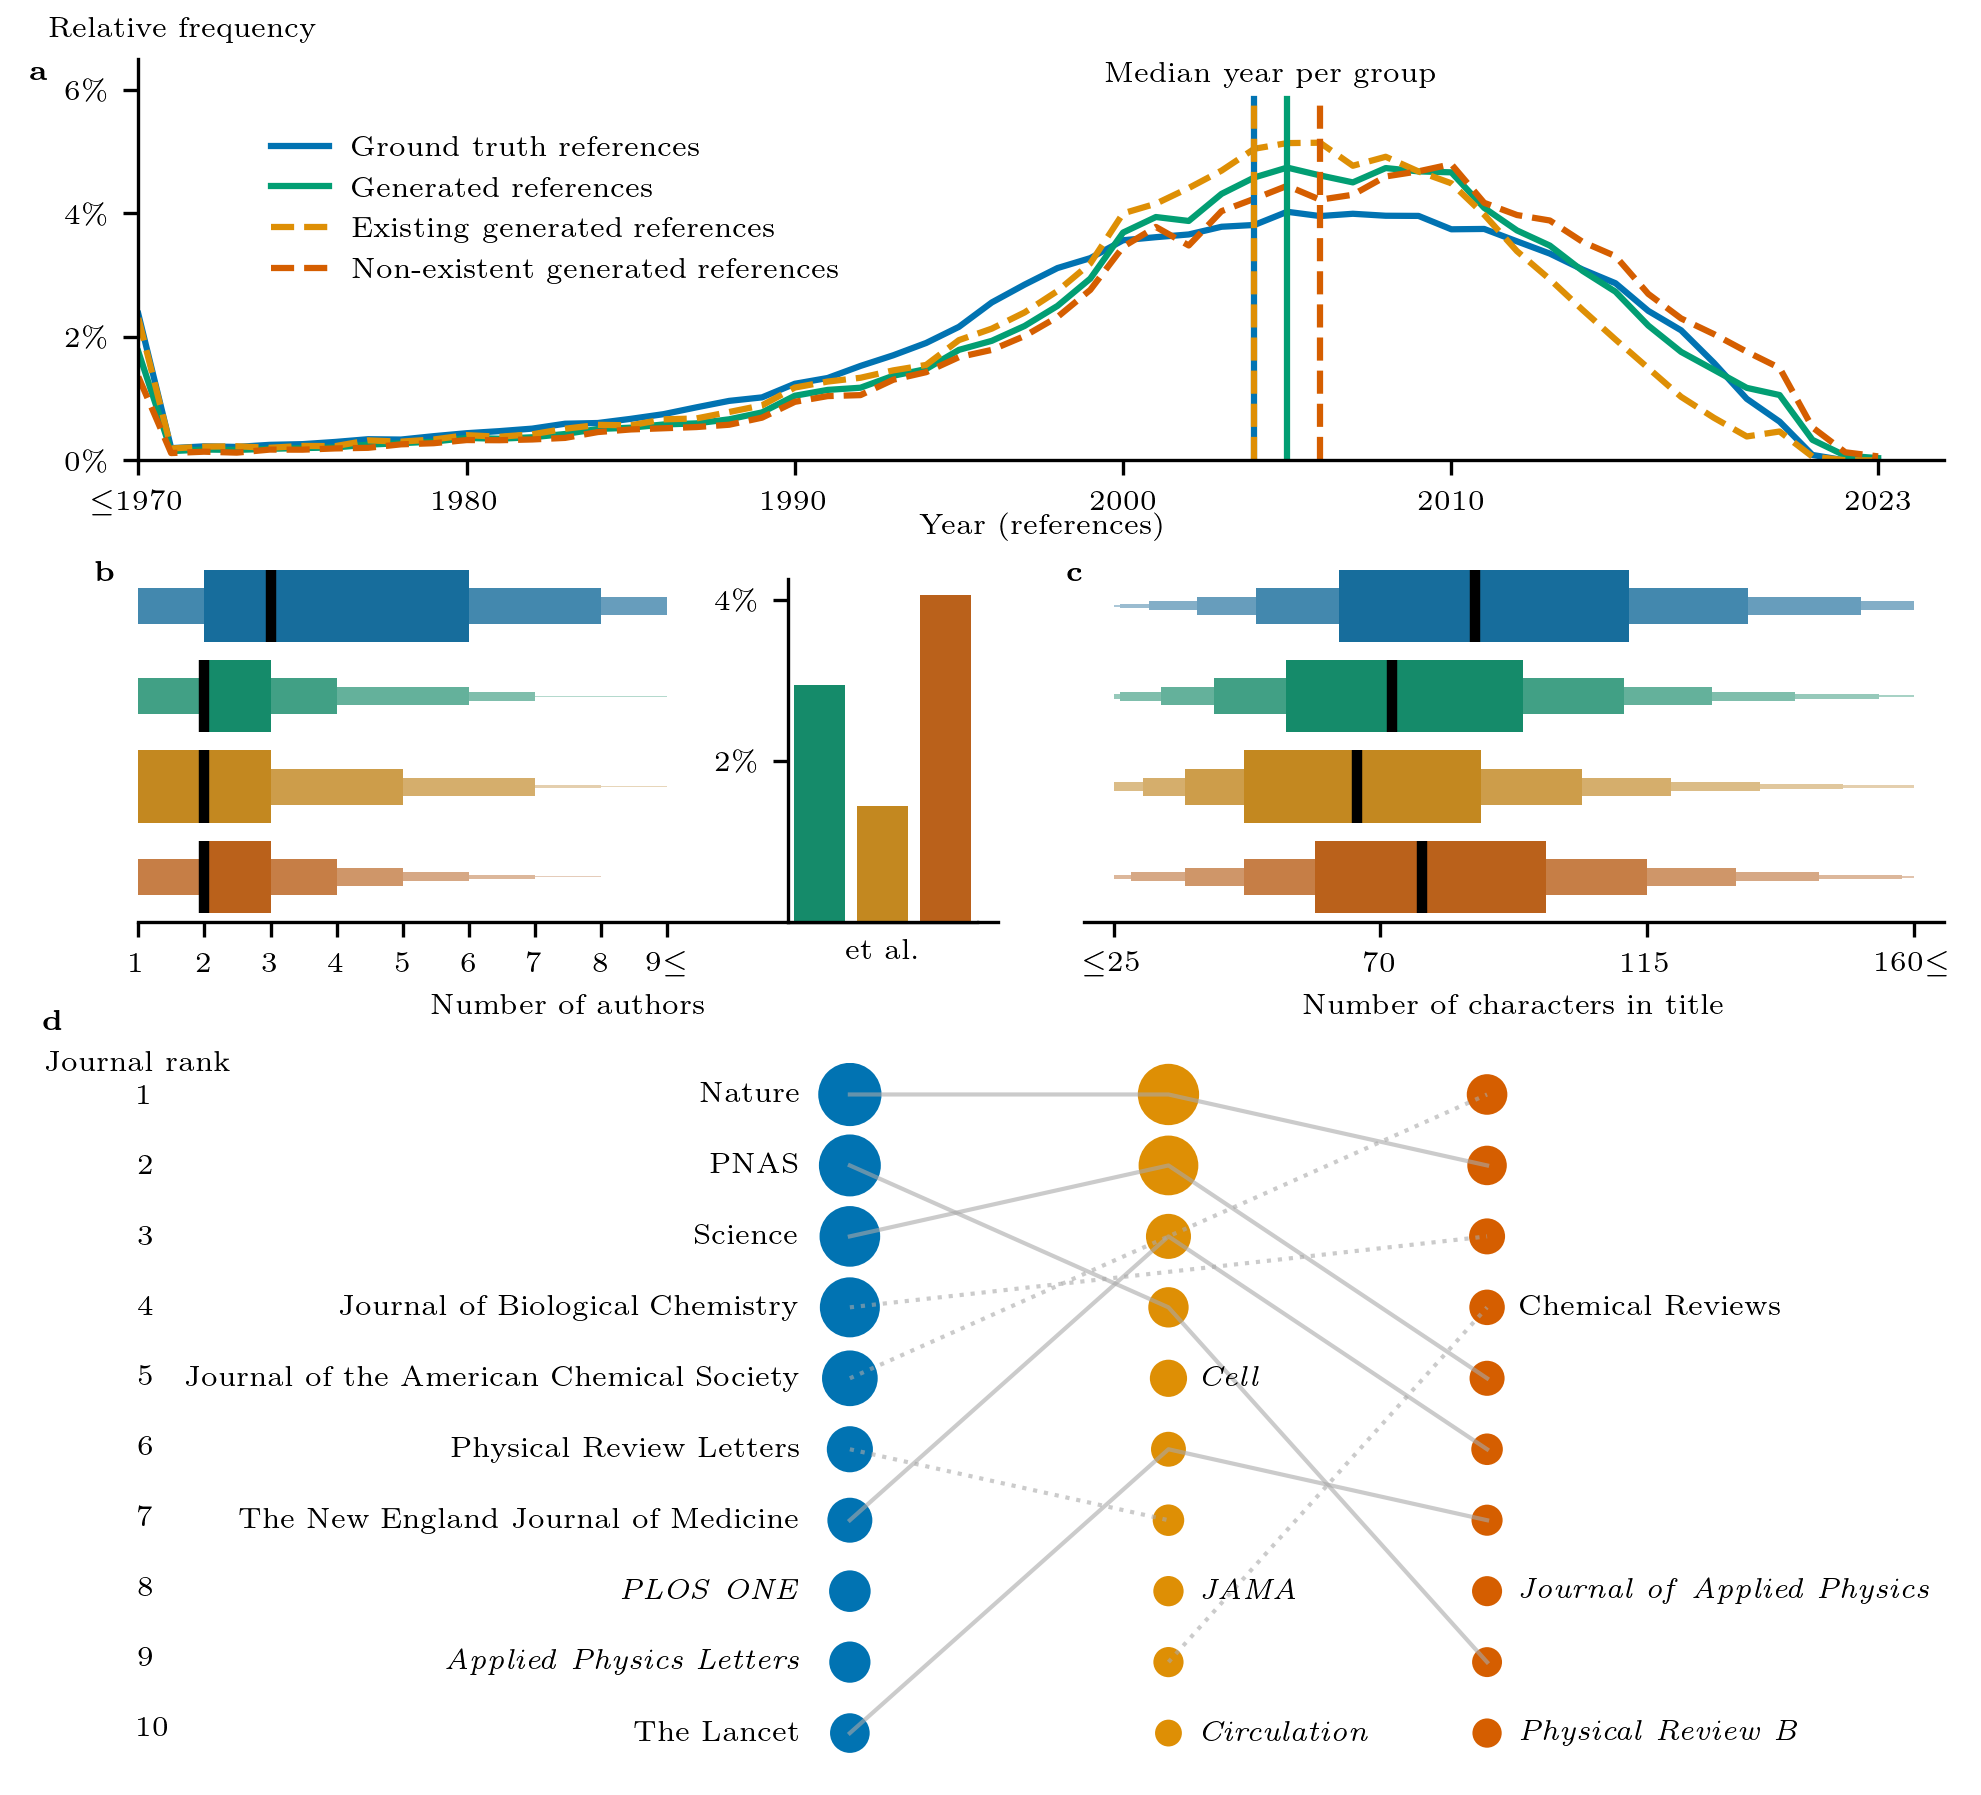

In [9]:
fig = plt.figure(figsize=(7.08, 6.69), dpi=300)

gs_upper = fig.add_gridspec(
    nrows=1, ncols=1, left=0.1, right=0.95, top=0.95, bottom=0.75, hspace=0.5, wspace=0
)
gs_middle = fig.add_gridspec(
    nrows=1, ncols=2, left=0.1, right=0.95, top=0.7, bottom=0.52, hspace=0.5, wspace=0.1
)
gs_lower = fig.add_gridspec(
    nrows=1, ncols=1, left=0.42, right=0.75, top=0.45, bottom=0.1, hspace=0.5, wspace=0
)

# Add subplots
ax_a = fig.add_subplot(gs_upper[0, 0])  # Upper section for panel A (spans entire width)
ax_d = fig.add_subplot(gs_middle[0, 0])  # Middle-left for panel D
ax_e = fig.add_subplot(gs_middle[0, 1])  # Middle-right for panel E
ax_b = fig.add_subplot(gs_lower[0, 0])  # Lower section for panel B (spans entire width)

ax3 = {'A': ax_a, 'D': ax_d, 'E': ax_e, 'B': ax_b}
Figure3 = fig

# A
sns.lineplot(
    x=all_years, y=intro_year, color='#0173b2', linewidth=1.5, ax=ax3["A"]
)
sns.lineplot(
    x=all_years, y=gen_year, color='#029e73', linewidth=1.5, ax=ax3["A"]
)
sns.lineplot(
    x=all_years, y=exist_year, color='#de8f05', linewidth=1.5, linestyle='--', ax=ax3["A"]
)
sns.lineplot(
    x=all_years, y=non_exist_year, color='#d55e00', linewidth=1.5, linestyle='--', ax=ax3["A"]
)

ax3["A"].set(xlim=(starting_year, 2025))
ax3["A"].set_xlabel("Year (references)", fontsize=7, labelpad=-1)
ax3["A"].set_ylabel("Relative frequency", fontsize=7, rotation=0)
ax3["A"].yaxis.set_label_coords(0.025, 1.04)
ax3["A"].set_xticks(
    ticks=[1970, 1980, 1990, 2000, 2010, 2023],
    labels=[r"$\small\leq$1970", "1980", "1990", "2000", "2010", "2023"],
    fontsize=7,
)
ax3["A"].set_yticks(
    [0,0.02,0.04,0.06],
    labels=[r"0$\%$",r"2$\%$",r"4$\%$",r"6$\%$"],
    fontsize=7,
)
ax3["A"].set_title("")

ax3["A"].set(ylim=(0, 0.065))

sns.despine(ax=ax3["A"],left=False, bottom=False)

# add vertical line indicating averages per group
ax3["A"].annotate(
    r"Median year per group",
    xy=(2004.5, 0.0625),
    ha='center',
    va='center',
    fontsize=7,
)
ax3["A"].axvline(
    df_ground_truth[
        "Publication Year_limited"
    ].median(),
    ymax=0.9,
    color="#0173b2",
    linewidth=1.5,
)
ax3["A"].axvline(
    df_generated[
        "Publication Year_limited"
    ].median(),
    ymax=0.9,
    color="#029e73",
    linewidth=1.5,
)
ax3["A"].axvline(
    df_generated[
        df_generated["Exists"] == 1
    ]["Publication Year_limited"].median(),
    ymax=0.9,
    color="#de8f05",
    linestyle='--',
    linewidth=1.5,
)
ax3["A"].axvline(
    df_generated[
        df_generated["Exists"] == 0
    ]["Publication Year_limited"].median(),
    ymax=0.9,
    color="#d55e00",
    linestyle='--',
    linewidth=1.5,
)

# journals
categories_of_interest = {"Ground truth", "Existing generations", "Non-existent generations"}

for journal, subdf in df.groupby("Journal"):
    subdf = subdf.sort_values("Category")

    # Figure out how many of the three categories this journal actually appears in
    cats_here = set(subdf["Category"]) & categories_of_interest
    num_cats = len(cats_here)
    
    # Line style: dotted if exactly two of the three categories, else solid
    if num_cats == 2:
        ls = "dotted"
    else:
        ls = "solid"
    
    # Plot each journal’s line by hand
    ax3["B"].plot(
        subdf["Category"],
        subdf["Rank"],
        color="darkgray",
        alpha=0.6,
        linewidth=1,
        linestyle=ls,
    )
    
    # For annotation text: italic if it does NOT appear in all three
    if num_cats < 2:
        label_text = rf"$\it{{{journal.replace(' ', r'\ ')}}}$"
    else:
        label_text = journal
    
    # Figure out the coordinate for labeling (e.g., last valid row)
    last_row = subdf.dropna(subset=["Rank"]).iloc[-1]
    x_pos = last_row["Category"]
    y_pos = last_row["Rank"]

    # Decide where to place the label
    if "Ground truth" in cats_here:
        # Label at the Ground truth point, on the left side
        gt_row = subdf[subdf["Category"]=="Ground truth"].iloc[0]
        x_pos = gt_row["Category"]
        y_pos = gt_row["Rank"]
        ax3["B"].annotate(
            label_text,
            xy=(x_pos, y_pos),
            xytext=(-12, 0),
            textcoords='offset points',
            va='center',
            ha='right',   # anchor text to the right so it appears left of the point
            fontsize=7,
        )
    else:
        # Otherwise label at the last row (e.g., existing or non‐existent),
        # with the text on the right side
        last_row = subdf.dropna(subset=["Rank"]).iloc[-1]
        x_pos = last_row["Category"]
        y_pos = last_row["Rank"]
        ax3["B"].annotate(
            label_text,
            xy=(x_pos, y_pos),
            xytext=(8, 0),
            textcoords='offset points',
            va='center',
            ha='left',
            fontsize=7,
        )

# Scatter points, sized by frequency
sns.scatterplot(
    data=df,
    x="Category", y="Rank",
    hue="Category",
    size="Frequency",
    palette=["#0173b2", "#de8f05", "#d55e00"],
    sizes=(50, 250),
    legend=False,
    ax=ax3["B"],
)

ax3["B"].invert_yaxis()
ax3["B"].set_title(" ")

ax3["B"].set_xlabel("", fontsize=7)
ax3["B"].set_ylabel("Journal rank", fontsize=7, rotation=0)
ax3["B"].yaxis.set_label_coords(-0.97, 0.98)

ax3["B"].tick_params(left=False, bottom=False)
ax3["B"].set_yticks(
    ticks=[],
    labels=[],
    fontsize=7,
)
for label in ax3["B"].get_yticklabels():
    label.set_ha('center')
    label.set_x(0.02)  

ax3["B"].set_xticks(
    ticks=[],
    # labels=["Ground truth", "Existing generations", "Non-existent generations"],
    # fontsize=7,
)
for label in ax3["B"].get_xticklabels():
    label.set_ha('center')
    label.set_y(0.03) 

sns.despine(ax=ax3["B"], left=True, bottom=True)

# legend
# legend should be lines, not patches
legend_elements = [
    mlines.Line2D(
        [], [], color='#0173b2', linestyle='-', linewidth=1.5,
        label='Ground truth references'
    ),
    mlines.Line2D(
        [], [], color='#029e73', linestyle='-', linewidth=1.5,
        label='Generated references'
    ),
    mlines.Line2D(
        [], [], color='#de8f05', linestyle='--', linewidth=1.5,
        label='Existing generated references'
    ),
    mlines.Line2D(
        [], [], color='#d55e00', linestyle='--', linewidth=1.5,
        label='Non-existent generated references'
    ),
]

# D
sns.boxenplot(
    data=df_authors,
    x="Number of Authors",
    y="Category",
    palette=["#0173b2", "#029e73", "#de8f05", "#d55e00"],
    order=["groundtruth", "gen", "exist", "not_exist"],
    edgecolor=None,
    linecolor='black',
    linewidth=2,
    showfliers=False,
    hue="Category",
    ax=ax3["D"],
)

ax3["D"].set(xlim=(1,14))
ax3["D"].set_xlabel("Number of authors", fontsize=7)
ax3["D"].set_ylabel("")
ax3["D"].set_xticks(ticks=[1,2,3,4,5,6,7,8,9], labels=["1","2","3","4","5","6","7","8",r"9$\small \leq$"], fontsize=7)
# ax1["D"].set_yticks(ticks=[1.5], labels=["Number of Authors"], fontsize="7")
ax3["D"].set_yticks([])
ax3["D"].set_title("")
sns.despine(ax=ax3["D"],left=True, bottom=False)

# side plot with et al.
etal_ax = inset_axes(
    ax3["D"], width="22%", height="95%", loc='lower right',
    bbox_to_anchor=(0, -0.058, 1, 1), bbox_transform=ax3['D'].transAxes
)

sns.barplot(
    x=etal_authors.index.to_list(),
    y=etal_authors.values,
    palette=["#de8f05", "#029e73", "#d55e00"],
    order=["gen", "exist", "not_exist"],
    hue=etal_authors.values,
    ax=etal_ax,
)

etal_ax.get_legend().set_visible(False)

etal_ax.set_xlabel("et al.", fontsize=7)
etal_ax.set_ylabel("")
etal_ax.set_xticks([])
etal_ax.set_yticks([0.02,0.04], labels=[r"2$\%$", r"4$\%$"], fontsize=7)
etal_ax.set_title("")
sns.despine(ax=etal_ax,left=False, bottom=False)

# E
sns.boxenplot(
    data=df_length,
    x="Title Length",
    y="Category",
    ax=ax3["E"],
    palette=["#0173b2", "#029e73", "#de8f05", "#d55e00"],
    order=["intro", "gen", "exist", "not_exist"],
    edgecolor=None,
    linecolor='black',
    linewidth=2,
    showfliers=False,
    hue="Category",
)

ax3["E"].set(xlim=(20,165))
ax3["E"].set_xlabel("Number of characters in title", fontsize=7)
ax3["E"].set_ylabel("")
ax3["E"].set_xticks(ticks=[25,70,115,160], labels=[r"$\small \leq$25","70","115",r"160$ \small \leq$"], fontsize=7)
ax3["E"].set_yticks([])
ax3["E"].set_title("")
sns.despine(ax=ax3["E"],left=True, bottom=False)

# legend
ax3["B"].legend(
    handles=legend_elements,
    loc='upper left',
    title='',
    title_fontsize=7,
    fontsize=7,
    frameon=False,
    bbox_transform=Figure3.transFigure,
    bbox_to_anchor=(0.15, 0.925),
)

# annotations
ax3["A"].text(-0.06, 1, r'\textbf{a}', transform=ax3["A"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["D"].text(-0.05, 1.0, r'\textbf{b}', transform=ax3["D"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["E"].text(-0.02, 1.0, r'\textbf{c}', transform=ax3["E"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["B"].text(-1.105, 1.075, r'\textbf{d}', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')

ax3["B"].text(-0.97, 0.97, r'1', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["B"].text(-0.97, 0.87, r'2', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["B"].text(-0.97, 0.77, r'3', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["B"].text(-0.97, 0.67, r'4', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["B"].text(-0.97, 0.57, r'5', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["B"].text(-0.97, 0.47, r'6', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["B"].text(-0.97, 0.37, r'7', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["B"].text(-0.97, 0.27, r'8', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["B"].text(-0.97, 0.17, r'9', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')
ax3["B"].text(-0.97, 0.07, r'10', transform=ax3["B"].transAxes, 
              fontsize=7, fontweight='bold', va='top', ha='left')